In [2]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


# 1 - Problem Deutcha

## Na czym polega
W problemie mamy daną czarną skrzynkę implementującą jakąś funkcję, która zwraca 0 albo 1. Należy sprawdzić czy jest ona stała czy zmienna (dokladniej - mamy zagwarantowane że albo jest stała albo zwraca 1 dla jednej połowy dziedziny, 0 dla drugiej)   

Dla problemu jedno bitowego/kubitowego może to być jedna z 4 funkcji

## Bramki U<sub>f</sub>

In [23]:
# stała
def f0(circ):
    return

# zmienna
def f1(circ):
    circ.cx(0, 1)
    
# zmienna
def f2(circ):
    circ.x(1)
    circ.cx(0, 1)
    
# stała
def f3(circ):
    circ.x(1)

In [24]:
def add_h(circ):
    circ.h(range(circ.n_qubits))

In [35]:
def create_deutch_circuit(function):
    circ = QuantumCircuit(2)
    circ.x(1)
    circ.barrier(range(2))
    add_h(circ)
    function(circ)
    add_h(circ)
    return circ

Przykładowo - funkcja f1 obłożona hadamardami. Dodatkowo X na początku - żeby zmienić kubit z 0 na 1

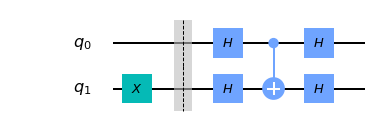

In [53]:
circ = create_deutch_circuit(f1)
circ.draw()

In [26]:
def run(circ, backend):
    size = circ.n_qubits
    meas = QuantumCircuit(size, size)
    meas.barrier(range(size))
    meas.measure(range(size),range(size))
    qc = circ+meas
    job = execute(qc, backend, shots=1024)
    result = job.result()
    return result.get_counts(qc)

In [46]:
backend_sim = Aer.get_backend('qasm_simulator')
sim_counts = []
legend = ["f1", "f2", "f3", "f4"]
sim_counts.append(run(create_deutch_circuit(f0), backend_sim))
sim_counts.append(run(create_deutch_circuit(f1), backend_sim))
sim_counts.append(run(create_deutch_circuit(f2), backend_sim))
sim_counts.append(run(create_deutch_circuit(f3), backend_sim))

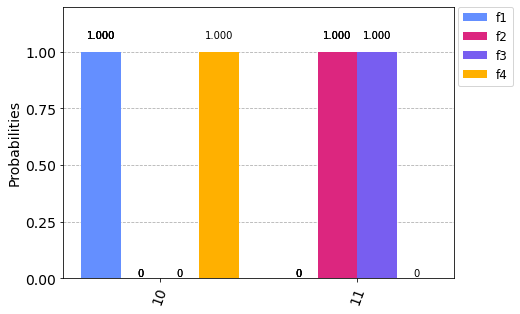

In [48]:
plot_histogram(sim_counts, legend=legend)

Wynik na kubicie q<sub>0</sub>.

Widać, że dla funkcji stałych (f2 i f4) jest ustawiony na 0, a dla stałych na 1

In [52]:
provider = IBMQ.get_provider(group='open')
backend = provider.get_backend('ibmq_essex')
real_counts = []
real_counts.append(run(create_deutch_circuit(f0), backend))
real_counts.append(run(create_deutch_circuit(f1), backend))
real_counts.append(run(create_deutch_circuit(f2), backend))
real_counts.append(run(create_deutch_circuit(f3), backend))

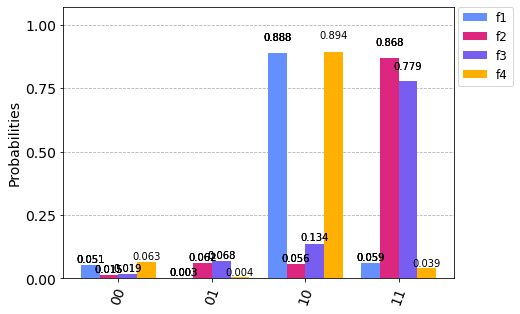

In [54]:
plot_histogram(real_counts, legend=legend)

Rzeczywsita maszyna daje podobne wyniki - prawdopodobieństwo poprawnych rozwiązań jest znacznie większe niż pzostałych

# 2 - Problem Bernsteina-Vaziraniego

## Na czym polega
Mamy funkcję z n-bitowym parametrem `a`. Pytanie - ile razy musimy uruchomić funkcję żeby znaleźć ten parametr.

In [111]:
def add_quantun_bv_function(circ, a):
    size = len(a)
    for i in range(size):
        if a[i]:
            circ.cx(i, size)

Przykładowa bramka z `a = [0,1,1,0]`. Kubity od q<sub>0</sub> do q<sub>3</sub> - wejście, kubit q<sub>4</sub> - wyjście

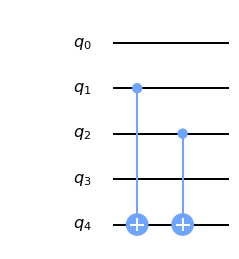

In [119]:
circ = QuantumCircuit(5)
add_quantun_bv_function(circ, [0,1,1,0])
circ.draw()

In [112]:
a = [0, 1, 1, 0]

## Roziązanie klasyczne

In [116]:
def classical_bv_solution(a, backend):
    counts = []
    size = len(a) + 1
    for i in range(len(a)):
        circ = QuantumCircuit(size)
        circ.x(i)
        circ.barrier()
        add_quantun_bv_function(circ, [0,1,1,0])
        counts.append(run(circ, backend))
    return counts

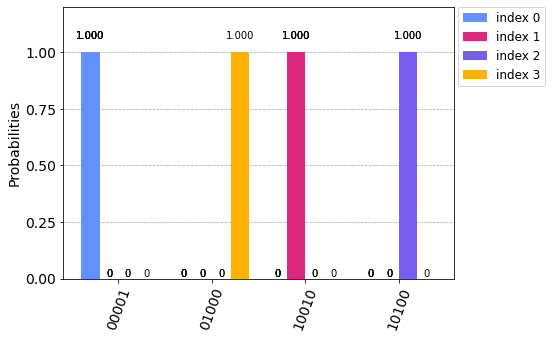

In [117]:
backend_sim = Aer.get_backend('qasm_simulator')
counts_sim_classical = classical_bv_solution(a, backend_sim)
plot_histogram(counts_sim_classical, legend=["index 0", "index 1", "index 2", "index 3"])

W rozwiązaniu klasycznym uruchamiamy funkcję `n` razy (gdzie `n` - długość paramtetru `a`), za każdym razem ustawiając 1 na jednym bicie wejściowym (w tym przypadku kubicie - od q<sub>0</sub> do q<sub>3</sub>). Rozwiązanie pojawia się na kubicie wyjściowym q<sub>4</sub>. W tym przypadku odpowiedzią jest a = 0110 - zgodne z paramtrem podanym na początku.

In [ ]:
provider = IBMQ.get_provider(group='open')
backend = provider.get_backend('ibmq_essex')
counts_sim_classical = classical_bv_solution(a, backend)

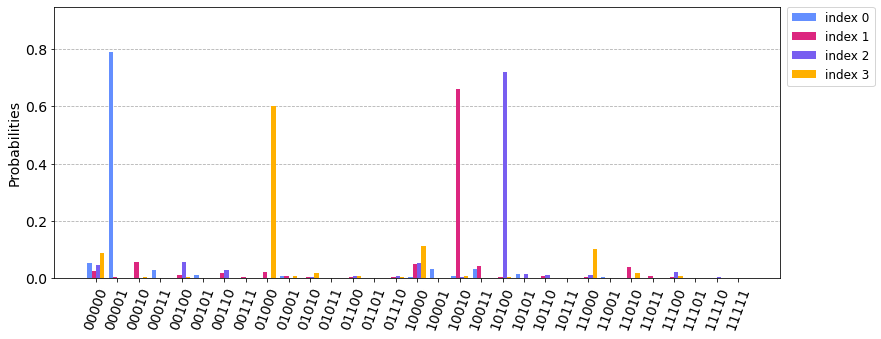

In [124]:
plot_histogram(counts_sim_classical, legend=["index 0", "index 1", "index 2", "index 3"], bar_labels=False, figsize=(13,5))

Rzeczywisty komputer przypisuje największe prawdopodobieństwo prawdziwemu wynikowi.

## Rozwiązanie kwantowe

In [106]:
def create_bv_circuit(a):
    size = len(a)
    circ = QuantumCircuit(size+1)
    circ.x(size)
    circ.barrier()
    add_h(circ)
    add_quantun_bv_function(circ, a)
    add_h(circ)
    return circ

Obkładamy bramkę realizującą funkcję Bernsteina-Vaziraniego hadamardami, oraz ustawiamy kubit wyjściowy q<sub>4</sub> na 1

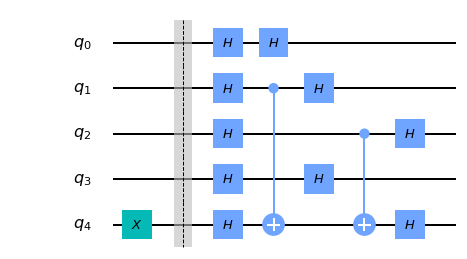

In [107]:
circ = create_bv_circuit(a)
circ.draw()

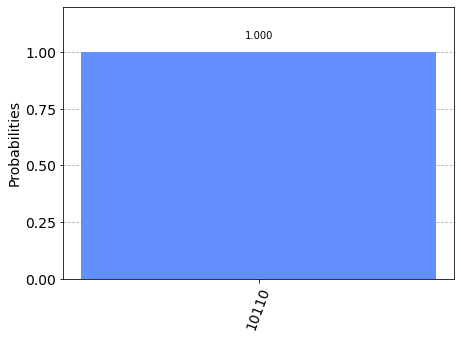

In [108]:
backend_sim = Aer.get_backend('qasm_simulator')
sim_counts_bv = run(circ, backend_sim)
plot_histogram(sim_counts_bv)

W tym przypadku wystarczy pojedyncze uruchomienie obwodu - odpowiedź jest na kubitach wejściowych - w tym przypadku 0110, czyli poprawna

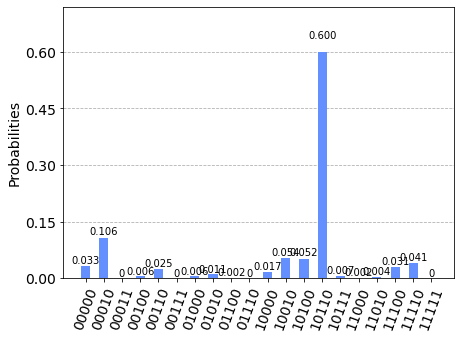

In [109]:
provider = IBMQ.get_provider(group='open')
backend = provider.get_backend('ibmq_essex')
real_counts_bv = run(circ, backend)
plot_histogram(real_counts_bv)

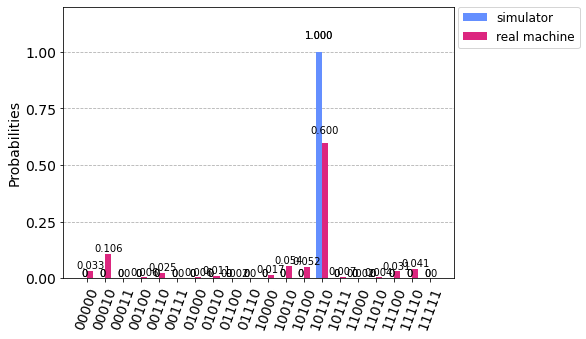

In [110]:
plot_histogram([sim_counts_bv, real_counts_bv], legend=["simulator", "real machine"])

Rzeczywisty komputer kwantowy daje największe prawdopodobieństwo prawdziwemu wynikowi